# Tutorial Julia for Data Science

## 8 Problemi di ottimizzazione

Questa parte riguarda definizione di problemi di ottimizzazione tramite modelli e la loro risoluzione.  
Vedremo vari problemi di tipo comune e come risolverli.  
Useremo molto funzionalità del pacchetto JuMP.jl.  
Iniziamo inizializzando ambiente:

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

Pkg.resolve()

mkpath("downloads")
mkpath("out")

 Activating environment at `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\tutorial\Project.toml`
No Changes to `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\tutorial\Project.toml`
No Changes to `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\tutorial\Manifest.toml`


"out"

In [2]:
using Pkg
using Convex
using SCS
using XLSX
using DataFrames
using Plots
using CSV
using Statistics
using Images
using DelimitedFiles
using JuMP
using GLPK

### 1- Portfolio Investment
In questo problema abbiamo un qualche budget che dobbiamo investire in alcuni tipi di azioni cercando di ottenere un ritorno che superi una determinata soglia percentuale minimizzando il fattore di rischio.    
Iniziamo scaricando e dando un occhio a dei dati sull'andamento dei prezzi di queste azioini:

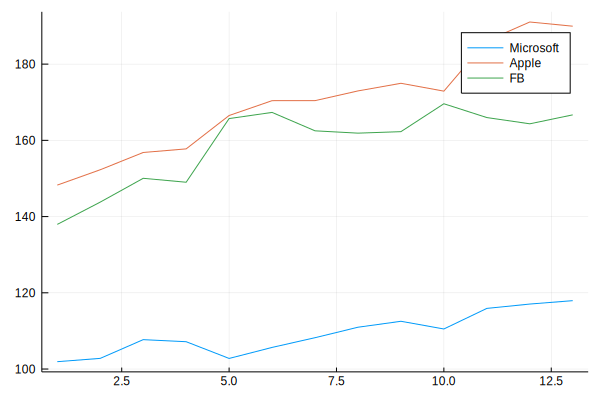

In [11]:
download("https://github.com/JuliaAcademy/DataScience/blob/master/data/stock_prices.xlsx?raw=true", "downloads/stock_prices.xlsx")
prices_matrix = Matrix(T)
T = DataFrame(XLSX.readtable("downloads/stock_prices.xlsx","Sheet2")...)
M1 = prices_matrix[1:end-1,:]
M2 = prices_matrix[2:end,:]
R = (M2.-M1)./M1

plot(T[!,:MSFT],label="Microsoft")
plot!(T[!,:AAPL],label="Apple")
plot!(T[!,:FB],label="FB")

Il nostro problema avrà forma:
$$ min(x^TMx) $$

$$
 \begin{eqnarray}   
 x = & \begin{vmatrix}
 x_1 = \mbox{porzione di budget investito in MSFT}\\
x_2 = \mbox{porzione di budget investito in FB}\\  
x_3 = \mbox{porzione di budget investito in AAPL}\\  
\end{vmatrix}  & : \begin{array} x_1 + x_2 + x_3 = 1 \\ x >= 0 \end{array}\\
\\
r = & \begin{vmatrix}
 r_1 = \mbox{ritorno proporzionale di MSFT}\\
r_2 = \mbox{ritorno proporzionale di FB}\\  
r_3 = \mbox{ritorno proporzionale di AAPL}\\  
\end{vmatrix}  &  \\ 
 &\sum_{i=1}^{3}(r_i*x_i) >= 0.2
\end{eqnarray}  
$$

Le variabili $r$ sono variabili aleatorie che quindi tratteremo con il loro valore atteso 
$ E[ \sum_{i=1}^{3}(r_i*x_i)] = E[ \sum_{i=1}^{3}(E[r_i]*x_i)] $  
Iniziamo a definire il modello, partendo dalla matrice di rischio che sarà al matrice di covarianza:

In [12]:
risk_matrix = cov(R);

NB: è definita positiva:

In [13]:
isposdef(risk_matrix)

true

Calcoliamo il valore atteso di r:

In [14]:
r = mean(R,dims=1)[:]

3-element Array{Float64,1}:
 0.012532748705136572
 0.016563036855293173
 0.02114580465503291

Definiamo il problema:

In [15]:
x = Variable(length(r))
problem = minimize(x'*risk_matrix*x,[sum(x)==1;r'*x>=0.02;x.>=0])

minimize
└─ * (Convex.NotDcp; real)
   ├─ * (affine; real)
   │  ├─ adjoint (affine; real)
   │  │  └─ …
   │  └─ 3×3 Array{Float64,2}
   └─ 3-element real variable (id: 108…509)
subject to
├─ == constraint (affine)
│  ├─ sum (affine; real)
│  │  └─ 3-element real variable (id: 108…509)
│  └─ 1
├─ >= constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ [0.0125327 0.016563 0.0211458]
│  │  └─ 3-element real variable (id: 108…509)
│  └─ 0.02
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 108…509)
│  └─ 0
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 108…509)
│  └─ 0
└─ >= constraint (affine)
   ├─ index (affine; real)
   │  └─ 3-element real variable (id: 108…509)
   └─ 0

status: `solve!` not called yet

┌ Warning: Expression not DCP compliant. Trying to solve non-DCP compliant problems can lead to unexpected behavior.
└ @ Convex C:\Users\i am\.julia\packages\Convex\aYxJA\src\dcp.jl:25


Il pacchetto Convex.jl richiede che i problemi siano definiti seguendo linee guida DCP: http://cvxr.com/cvx/doc/dcp.html  
Convertiamo il nostro problema in un problemas DCP compliant:  

In [16]:
problem = minimize(Convex.quadform(x,risk_matrix),[sum(x)==1;r'*x>=0.02;x.>=0])

minimize
└─ * (convex; positive)
   ├─ 1
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0]
subject to
├─ == constraint (affine)
│  ├─ sum (affine; real)
│  │  └─ 3-element real variable (id: 108…509)
│  └─ 1
├─ >= constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ [0.0125327 0.016563 0.0211458]
│  │  └─ 3-element real variable (id: 108…509)
│  └─ 0.02
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 108…509)
│  └─ 0
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 108…509)
│  └─ 0
└─ >= constraint (affine)
   ├─ index (affine; real)
   │  └─ 3-element real variable (id: 108…509)
   └─ 0

status: `solve!` not called yet

In [17]:
solve!(problem, SCS.Optimizer)

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 24, CG tol ~ 1/iter^(2.00)
eps = 1.00e-005, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-003
Variables n = 6, constraints m = 14
Cones:	primal zero / dual free vars: 2
	linear vars: 5
	soc vars: 7, soc blks: 2
Setup time: 4.04e-005s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|1.71e+019 2.86e+019 1.00e+000 -3.40e+019 5.17e+018 5.49e+019 1.80e-005 
    97|4.78e-011 1.28e-010 1.08e-010 4.85e-004 4.85e-004 3.76e-017 3.86e-004 
-------------------------------------------

In [19]:
@show ((r'*x.value)*100)[1]

@show x.value .* 1000;

((r' * x.value) * 100)[1] = 2.0000000000662013
x.value .* 1000 = [67.95414742252918; 122.30857118794069; 809.7372814405625]


Quindi la soluzione che minimizza il rischio è di investire 67\\$ in azioni MSFT, 122\\$ in azioni FB e 809\\$ in azioni AAPL.  
Così facendo ci aspetteremo di avere un ritorno del 2%

### 2- Image Recovery
Per questo problema dovremo cercare di ricostruire un immagine partendo dall immagine corrotta.  
Per simulare il problema prenderemo un immagine e azzereremo circa 4000 pixel casuali.  

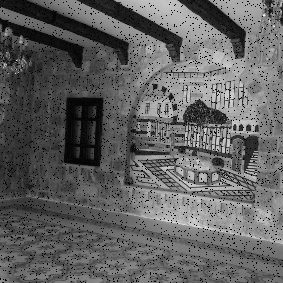

In [20]:
download("https://github.com/JuliaAcademy/DataScience/blob/master/data/khiam-small.jpg?raw=true", "downloads/khiam-small.jpg")
Kref = load("downloads/khiam-small.jpg")
K = copy(Kref)
Gray.(K)

#creiamo dei pixel mancanti
p = prod(size(K))
missingids = rand(1:p,4000)
K[missingids] .= RGBX{N0f8}(0.0,0.0,0.0)
gK =Gray.(K)

Tratteremo l'immagine in scala di grigio per comodità di conversione in matrice.

In [21]:
Y = Float64.(gK);

Il problema di ricostruzione di immagine è ora trasformato in problema di ricostruzione di matrice.  
L'algoritmo di Convex.jl che useremo ricreererà la matrice (immagine) X tale che X abbia norma nucleare minima e che i valori di Y che noi dichiariamo essere definiti non vengano cambiati.

In [22]:
correctids = findall(Y[:].!=0)
X = Convex.Variable(size(Y))
problem = minimize(nuclearnorm(X))
problem.constraints += X[correctids]==Y[correctids]

1-element Array{Constraint,1}:
 == constraint (affine)
├─ index (affine; real)
│  └─ 283×283 real variable (id: 178…722)
└─ 76203-element Array{Float64,1}

In [24]:
solve!(problem, SCS.Optimizer(eps=1e-3, alpha=1.5))

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 396843, CG tol ~ 1/iter^(2.00)
eps = 1.00e-003, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-003
Variables n = 240268, constraints m = 396560
Cones:	primal zero / dual free vars: 236099
	sd vars: 160461, sd blks: 1
Setup time: 6.23e-002s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|1.04e+021 5.63e+019 1.00e+000 -1.51e+024 1.40e+022 1.13e+024 2.88e-001 
   100|3.89e-002 2.37e-002 4.06e-004 4.35e+002 4.34e+002 3.28e-015 2.50e+001 
   200|2.04e-002 1.05e-002 1.72e-004 4

norm(float.(Gray.(Kref)) - X.value) = 3.584411093374155
norm(-(X.value)) = 124.23019341044973


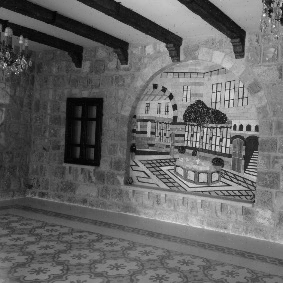

In [25]:
@show norm(float.(Gray.(Kref))-X.value)
@show norm(-X.value)
colorview(Gray, X.value)

A vista è difficile distinguere le immagini, è quindi un buon risultato.

### 3- Diet problem
Immaginiamo di avere una dieta che stabiliscie i limiti giornalieri di certe caratteristiche nutritive che possiamo mangiare.  
Vogliamo sapere quali ammontari di alimenti dovremmo comprare per raggiungere i limiti minimizzando la spesa.  
Risolveremo questo problema con JuMP.jl.  
Iniziamo dichiarando i nostri dati:  

In [26]:
category_data = JuMP.Containers.DenseAxisArray(
    [1800 2200;
     91   Inf;
     0    65;
     0    1779], 
    ["calories", "protein", "fat", "sodium"], 
    ["min", "max"])

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, ["calories", "protein", "fat", "sodium"]
    Dimension 2, ["min", "max"]
And data, a 4×2 Array{Float64,2}:
 1800.0  2200.0
   91.0    Inf
    0.0    65.0
    0.0  1779.0

Quello che abbiamo dichiarato adesso è praticamente una matrice le cue colonne possono essere indicizzate con "min", "max" e le cui righe possono essere indicizzate con "calories", "protein", "fat", "sodium".  

| | min | max|
|---|---|---|
|calories|1800|2200|
|protein| 91|inf|
|fat|0|65|
|sodium|0|1779|

In [27]:
@show category_data["calories","max"] 
@show category_data["fat","min"]
;

category_data["calories", "max"] = 2200.0
category_data["fat", "min"] = 0.0


Similarmente creiamo un dataset per i prezzi di alcuni alimenti:

In [28]:
foods = ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza","salad", "milk", "ice cream"]
cost = JuMP.Containers.DenseAxisArray(
    [2.49, 2.89, 1.50, 1.89, 2.09, 1.99, 2.49, 0.89, 1.59],
    foods);

Come ultimo dataset creiamone uno che associ agli alimenti dei coefficienti nutrizionali:

In [29]:
food_data = JuMP.Containers.DenseAxisArray(
    [410 24 26 730;#una riga è una riga contenente valori per "calories", "protein", "fat", "sodium" dell alimento
     420 32 10 1190;
     560 20 32 1800;
     380  4 19 270;
     320 12 10 930;
     320 15 12 820;
     320 31 12 1230;
     100  8 2.5 125;
     330  8 10 180], 
    foods, 
    ["calories", "protein", "fat", "sodium"])

@show food_data["chicken", "fat"]
@show food_data["milk", "sodium"]
;

food_data["chicken", "fat"] = 10.0
food_data["milk", "sodium"] = 125.0


Non ci rimane che creare il modello:

In [30]:
model = Model(GLPK.Optimizer)

categories = ["calories", "protein", "fat", "sodium"]

# add the variables https://jump.dev/JuMP.jl/dev/variables/
# https://jump.dev/JuMP.jl/dev/variables/#variables-1
@variables(model, begin#var definite tra beginning e end
    # Variables for nutrition info
    category_data[c, "min"] <= nutrition[c = categories] <= category_data[c, "max"]
    # Variables for which foods to buy
    buy[foods] >= 0
end)

# Objective - minimize cost
@objective(model, Min, sum(cost[f] * buy[f] for f in foods))
# minimizza sommatoria di (i comprati * costo di un i) per ogni alimento i

# Nutrition constraints
@constraint(model, [c in categories],
    sum(food_data[f, c] * buy[f] for f in foods) == nutrition[c]
)# vincolo sulla soluzione

1-dimensional DenseAxisArray{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.EqualTo{Float64}},ScalarShape},1,...} with index sets:
    Dimension 1, ["calories", "protein", "fat", "sodium"]
And data, a 4-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.EqualTo{Float64}},ScalarShape},1}:
 410 buy[hamburger] + 420 buy[chicken] + 560 buy[hot dog] + 380 buy[fries] + 320 buy[macaroni] + 320 buy[pizza] + 320 buy[salad] + 100 buy[milk] + 330 buy[ice cream] - nutrition[calories] == 0.0
 24 buy[hamburger] + 32 buy[chicken] + 20 buy[hot dog] + 4 buy[fries] + 12 buy[macaroni] + 15 buy[pizza] + 31 buy[salad] + 8 buy[milk] + 8 buy[ice cream] - nutrition[protein] == 0.0
 26 buy[hamburger] + 10 buy[chicken] + 32 buy[hot dog] + 19 buy[fries] + 10 buy[macaroni] + 12 buy[pizza] + 12 buy[salad] + 2.5 buy[milk] + 10 buy[ice cream] - nutrition[fat] == 0.0
 7

$$ min(\sum_{f:foods}(cost_fbuy_f)) $$

$$
 \begin{eqnarray}   
 & cost = [ c_f : \mbox{costo dell'alimento }f]&\\
 & buy = [ x_f : \mbox{numero di alimenti }f\mbox{ da comprare}]&\\
 & food\_data = \{ d_{fc} : \mbox{quantitativo di categoria }c\mbox{ dell'alimento }f \}&\\
 & nutrition = \{ n_c :  \sum_{f:foods}(x_f*d_{fc})\} &\\
 & category\_data[c, "min"] \leq n_c  \leq category\_data[c, "max"] & \forall c:\mbox{category}
\end{eqnarray}  
$$

Avendo formulato il problema, possiamo risolverlo con JuMP:

In [31]:
JuMP.optimize!(model)
term_status = JuMP.termination_status(model)
is_optimal = term_status == MOI.OPTIMAL
@show JuMP.primal_status(model) == MOI.FEASIBLE_POINT
@show JuMP.objective_value(model) ≈ 11.8288 atol = 1e-4

JuMP.primal_status(model) == MOI.FEASIBLE_POINT = true
JuMP.objective_value(model) ≈ 11.8288 = false
atol = 0.0001 = 0.0001


0.0001

### 4- Passport Problem
Nel quarto ed ultimo problema vogliamo sapere l'insieme minimo di passaporti che ci permettono di visitare il mondo senza ottenere VISA prima.  
Inanzitutto carichiamo un dataframe che ci dice quali nazioni possono essere visitate con quali passaporti senza visa:

In [33]:
download("https://github.com/ilyankou/passport-index-dataset/raw/master/passport-index-matrix.csv","downloads/passport-index-matrix.csv")
passportdata = readdlm("downloads/passport-index-matrix.csv", ',')

200×200 Array{Any,2}:
 "Passport"              …    "Yemen"    "Zambia"    "Zimbabwe"
 "Afghanistan"                "VR"       "VR"        "VR"
 "Albania"                    "VR"       "ETA"       "ETA"
 "Algeria"                    "ETA"      "VR"        "ETA"
 "Andorra"                    "VR"       "ETA"       "ETA"
 "Angola"                …    "VR"     30          90
 "Antigua and Barbuda"        "VR"     90          90
 "Argentina"                  "VR"       "ETA"       "ETA"
 "Armenia"                    "VR"       "VR"        "ETA"
 "Australia"                  "VR"       "ETA"       "ETA"
 "Austria"               …    "VR"       "ETA"       "ETA"
 "Azerbaijan"                 "VR"       "VR"        "ETA"
 "Bahamas"                    "VR"     90          90
 ⋮                       ⋱                         
 "United Arab Emirates"       "ETA"      "ETA"       "ETA"
 "United Kingdom"             "VR"       "ETA"       "ETA"
 "United States"         …    "VR"       "ETA"      

La categopria del df ha il seguente significato: 

| **Value** | **Explanation** |
|---|:---|
|7-360| number of visa-free days|
|VF| visa-free travel (where number of days is not applicable or known, eg freedom of movement)|
|VOA| visa on arrival|
|ETA| eTA (electronic travel authority) required|
|VR| visa required|
|-1| where passport=destination, in matrix files only|

Quindi se la nazione X ha "VF" o "VOA" con il passaporto della nazione Y, allora avendo passaporto Y possiamo andare a X senza premunirci di VISA.  
Iniziamo la costruzione del modello:  

In [40]:
cntr = passportdata[2:end,1]
vf = (x ->  typeof(x)==Int64 || x == "VF" || x == "VOA" ? 1 : 0).(passportdata[2:end,2:end]);
#steup  modello

model = Model(GLPK.Optimizer)
# GLPK è un wrapper della libreria GNU per la programmazione lineare
# GLPK.Optimizer crea un ottimizzatore da usare con JuMP o MathOptInterface

#aggiungi varibili, vinmcoli, fun obiettivo
@variable(model, pass[1:length(cntr)], Bin)#var
@constraint(model, [j=1:length(cntr)], sum( vf[i,j]*pass[i] for i in 1:length(cntr)) >= 1)#vincoli
@objective(model, Min, sum(pass));#funzione obiettivo, minimizzare

Abbiamo definito il modello per il nostro problema.  
Proviamo adesso a trovare la soluzione ottimale:


In [41]:
JuMP.optimize!(model)

In [43]:
print(JuMP.objective_value(model)," passporti : ",join(cntr[findall(JuMP.value.(pass) .== 1)],", "))

21.0 passporti : Afghanistan, Angola, Austria, Comoros, Congo, Eritrea, Gambia, Georgia, Hong Kong, India, Iraq, Kenya, Madagascar, Maldives, North Korea, Papua New Guinea, Seychelles, Singapore, Somalia, Tunisia, United Arab Emirates